# Genetic algorithm for Water Distribution Systems - Optimization project (2/2)

### ☑ <font color='#0096FF'>Blue-tape list<font><a class='anchor' id='top'></a>

<font color='#0096FF'>

- Depurate
- Revisit the background (Iterate with Riccardo for what to put and leave)
- Exclude the reservoirs from the restriction.
- Define more specific objectives
- Change the logos
- Change figures to improved versions stored online
- Cite exeter benchmarks
- Replace hard coded values
- Explain to the students what is happening inside the PyMOO syntax.
- Change TLN image

**Objectives:**
- Implement a genetic algorithm to find an appropriate solution for the optimization of a water distribution system.

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Defining the optimization problem
  - Solving the optimization problem
  - Analyzing the optimization problem
- Answered all the questions

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- Matplotlib
- WNTR
- PyMOO

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import wntr

#Genetic algorithm dependencies
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling

## 🔙 Background

### 💧 Water distribution systems

In cities, the layout of a water distribution system becomes more dense, and the consumption nodes are many more. 

Also, we want to provide redundancy in the system, this is, we want to ensure that there are more than one path that connects an user to the reservoir, in case of a failure in a pipe, the downstream users won't be disconnected from the system. Therefore, the system are now looped systems.

Water distribution system transports water from sources, like wells or reservoirs, to various locations where water is needed, like homes, shops, and factories.


Nevertheless, this increases the complexity of the problem for finding an optimal configuration of lenghts and diameters. Using the linear programming approach from the previous notebook would be impractical. First, there are 

First of all, 

For this problem, we won't consider the pipe lines as separable. This simplification reduces the number of decision variables.

Nevertheless, there are NP^D number of possibilities in the solution space.

We use a numerical model for calculating the pressure for all the nodes in a particular configuration of system.

Figure 1. Simplified scheme of a branched water distribution system.

### 🖥Numerical model

The Water Network Tool for Resilience (WNTR) is a powerful and flexible Python library designed for modeling, simulating, and analyzing water distribution systems. WNTR is based upon EPANET, which is a widely used software tool for simulating and analyzing water distribution systems. It plays a crucial role in the management and design of water distribution networks by enabling engineers and researchers to model, simulate, and optimize the complex interactions within these systems.

WNTR provides a comprehensive platform for engineers and researchers to investigate the hydraulic and water quality performance of water distribution networks. WNTR enables the simulation of water distribution systems by leveraging hydraulic and water quality models. Its core functionality is based on solving the network's governing equations for hydraulic behavior and water quality dynamics. 


EPANET's simulations are based on fundamental principles of fluid dynamics and mass transport within pipes, pumps, valves, and storage tanks.

<!-- 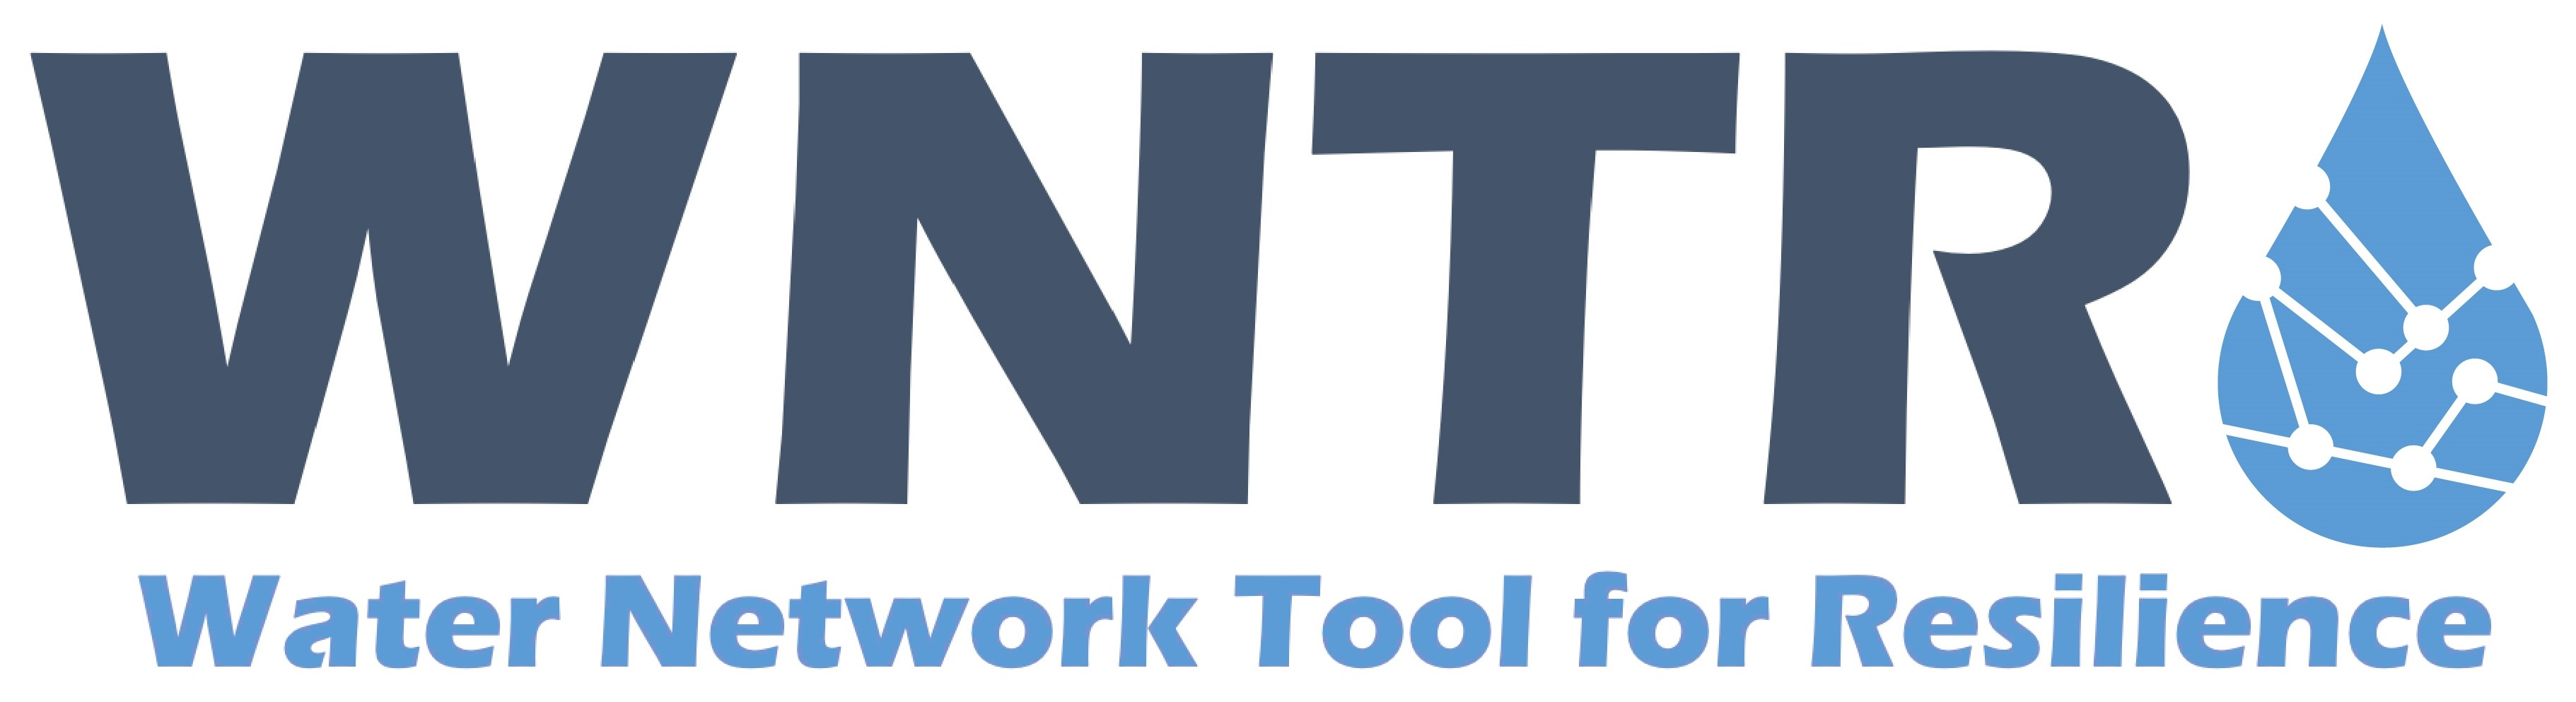 -->
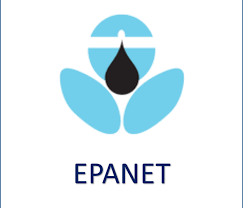

### 🧬Genetic algorithm

Genetic Algorithms (GAs) are powerful optimization techniques inspired by the process of natural evolution. They have gained prominence in solving complex problems across various fields, ranging from engineering and economics to artificial intelligence. This paper provides a comprehensive overview of Genetic Algorithms, highlighting their fundamental principles, components, and applications in solving optimization problems.

At the heart of a Genetic Algorithm are populations of potential solutions, represented as individuals or chromosomes. These individuals evolve over generations to improve their fitness with respect to the given optimization objective.

Basic Components of a Genetic Algorithm:
- **Population**: A collection of individuals representing potential solutions to the problem.
- **Fitness** Function: Quantifies the quality of each individual's solution with respect to the optimization objective.
- **Selection**: Individuals are chosen based on their fitness to serve as parents for the next generation.
- **Crossover**: Genetic material from parents is combined to create offspring with potentially improved traits.
- **Mutation**: Random changes are introduced in offspring to maintain diversity and explore new solution spaces.
- **Replacement**: New offspring replace some of the least fit individuals in the population.
- **Termination Criteria**: Conditions under which the algorithm stops, e.g., a maximum number of generations or satisfactory fitness level.

Working Principle:

- **Initialization**: A population of random individuals is generated to start the algorithm.
- **Evaluation**: The fitness function assesses the quality of each individual's solution.
- **Selection**: Individuals with higher fitness have a higher chance of being selected as parents.
- **Crossover**: Genetic material from selected parents is combined to create offspring.
- **Mutation**: Random changes are introduced to some offspring to maintain diversity.
- **Replacement**: New offspring replace some individuals in the population.
- **Termination**: The algorithm stops when a termination criterion is met.

PyMOO Library

## ⛔ Problem definition 

The problem is to find the pipe diameters that minimize the cost of the pipe lines while satisfying the customer demand for water usage and supply pressure. 

<!-- For this application, we will only consider systems feed by reservoirs that work via gravity. -->

### 🎯 Objective function

We want to minimize the cost of the pipes. Each pipe has a different cost according to its diameter and its length. Generally, the larger the pipe, the more expensive it is. 

We can define the total cost $Z$ of installing all the pipes as the following function
$$
\begin{align}
  & min Z = \sum_{j=1}^{N}C_{j}\sum_{i=1}^{M} L_{ij}\\
\end{align}
$$ (eq_cost_function)

where $C_{j}$ is the cost of pipe per meter-length having diameter $j$.

### 🚫 Restrictions

We consider one main restriction.

1) The water should arrive at the consumer nodes with sufficient pressure. This is, there should be sufficient energy for transporting the water from the source to each of nodes. This restriction can be written as

$$
\sum_{i=1}^{N} H_{i} \leq H^{*} 
$$

<!-- \; \text{for every node i in the system.} -->

## 💻 Genetic algorithm - Example

We exemplify the implementation of these algorithms with the system "Two loop network (TLN)". This system consists of one reservoir, six demand nodes and eight pipes organised in two loops. The reservoir has a constant head fixed at 210 m. As a hypothetical network all pipes have the same length (1000 m). The pressure is set to be at least 30.0 m at all demand nodes. The following table shows commercially available diameters and the corresponding unit costs (1 in.=0.0254 m). 

| Diameter [in] | 1    | 2    | 3    | 4    | 6    | 8    | 10   | 12   | 14   | 16   | 18   | 20   | 22   | 24   |
|-------------------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| Cost per meter [€/m] | 2    | 5    | 8    | 11   | 16   | 23   | 32   | 50   | 60   | 90   | 130  | 170  | 300  | 500  |


<!-- and the Hazen-Williams coefficient of 130. -->

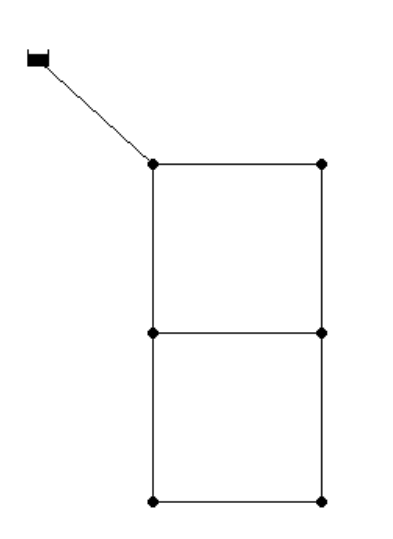

In [2]:
IN_TO_M = 0.0254

cost_function_diameter_inches = {
    1: 2,
    2: 5,
    3: 8,
    4: 11,
    6: 16,
    8: 23,
    10: 32,
    12: 50,
    14: 60,
    16: 90,
    18: 130,
    20: 170,
    22: 300,
    24: 500
}

pipe_index = {
    0:1,
    1:2,
    2:3,
    3:4,
    4:6,
    5:8,
    6:10,
    7:12,
    8:14,
    9:16,
    10:18,
    11:20,
    12:22,
    13:24
    }

H_star = 20

def transform_index_to_diameter(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

def transform_diameter_to_cost(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

WNTR

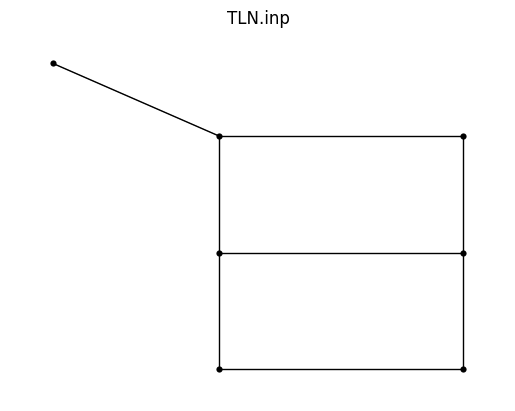

<Axes: title={'center': 'TLN.inp'}>

In [3]:
# Create a water network model
inp_file = 'TLN.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)

PyMOO

In [17]:
population_size = 100
class TwoLoopOptimization(Problem):

    def __init__(self):
        super().__init__(n_var=8, n_obj=1, n_ieq_constr=6, xl=0.0, xu=13.0, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        new_x = transform_index_to_diameter(x, pipe_index)
        pressure_heads = np.zeros((population_size, 6))
        individual_costs = np.zeros((population_size,1))
        
        for i, individual in enumerate(new_x):
            cost = 0
            for j, pipe_name in enumerate(wn.pipe_name_list):
                pipe = wn.get_link(pipe_name)
                # Modify the water network 
                pipe.diameter = individual[j] * IN_TO_M
                cost += cost_function_diameter_inches[individual[j]] * pipe.length
            
            individual_costs[i] = cost

            #Simulate the individual
            sim = wntr.sim.EpanetSimulator(wn)
            results = sim.run_sim()

            pressure_heads[i,:]= results.node['head'].values[0][:-1]
        
        out["F"] = individual_costs
        out["G"] = -(pressure_heads - H_star)

problem = TwoLoopOptimization()

method = GA(pop_size=population_size,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True,
            )

res = minimize(problem,
               method,
               termination=('n_gen', 100),
               seed=1,
               save_history=True,
               verbose=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      100 |  0.000000E+00 |  2.362708E+06 |  8.072500E+05 |  3.930000E+05
     2 |      200 |  0.000000E+00 |  6.800838E+01 |  8.195949E+05 |  3.190000E+05
     3 |      300 |  0.000000E+00 |  0.000000E+00 |  6.033500E+05 |  3.190000E+05
     4 |      400 |  0.000000E+00 |  0.000000E+00 |  4.825700E+05 |  2.800000E+05
     5 |      500 |  0.000000E+00 |  0.000000E+00 |  4.124900E+05 |  2.430000E+05
     6 |      600 |  0.000000E+00 |  0.000000E+00 |  3.521800E+05 |  2.280000E+05
     7 |      700 |  0.000000E+00 |  0.000000E+00 |  3.120000E+05 |  2.140000E+05
     8 |      800 |  0.000000E+00 |  0.000000E+00 |  2.811600E+05 |  2.130000E+05
     9 |      900 |  0.000000E+00 |  0.000000E+00 |  2.632800E+05 |  1.980000E+05
    10 |     1000 |  0.000000E+00 |  0.000000E+00 |  2.466500E+05 |  1.880000E+05
    11 |     1100 |  0.000000E+00 |  0.000000E+00 |  2.324100E+05 |  1.880000E+05
    12 |     120

Evaluate best solution

In [20]:
optimal_diameters = transform_index_to_diameter([res.X], pipe_index)[0]*IN_TO_M
print(optimal_diameters)

[0.305 0.102 0.254 0.203 0.254 0.203 0.025 0.025]


In [21]:
# Modify the water network
for j, pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    # Modify the water network 
    pipe.diameter = optimal_diameters[j]

In [22]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

In [23]:
results.node['head']

name,2,3,4,5,6,7,1
0,161.330154,45.874092,79.038292,53.587803,49.546474,35.241459,210.0


## 🏋🏽‍♀️ Exercise: Genetic algorithm

| Diameter [mm] |   100 |   125 |   150 |   200 |   250 |   300 |   350 |   400 |   450 |   500 |   600 |   700 |   800 |
|--------------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| Cost per meter [€/m] |  27.7 |  38.0 |  40.5 |  55.4 |  75.0 |  92.4 | 123.1 | 141.9 | 169.3 | 191.5 | 246.0 | 319.6 | 391.1 |


WNTR

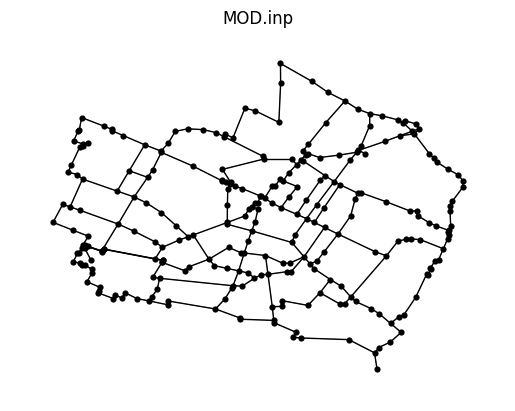

<Axes: title={'center': 'MOD.inp'}>

In [24]:
# Create a water network model
inp_file = 'MOD.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)


In [25]:
MM_TO_M = 0.001
cost_function_diameter_mm = {
    100: 27.7,
    125: 38.0,
    150: 40.5,
    200: 55.4,
    250: 75.0,
    300: 92.4,
    350: 123.1,
    400: 141.9,
    450: 169.3,
    500: 191.5,
    600: 246.0,
    700: 319.6,
    800: 391.1
}

pipe_index = {
    0:100,
    1:125,
    2:150,
    3:200,
    4:250,
    5:300,
    6:350,
    7:400,
    8:450,
    9:500,
    10:600,
    11:700,
    12:800,
    }

H_star = 20

def transform_index_to_diameter(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

def transform_diameter_to_cost(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

In [26]:
class ModenaOptimization(Problem):
    
    def __init__(self):
        super().__init__(n_var=317, n_obj=1, n_ieq_constr=268, xl=0.0, xu=12.0, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):

        new_x = transform_index_to_diameter(x, pipe_index)
        pressure_heads = np.zeros((20, 268))
        individual_costs = np.zeros((20,1))
        # Modify the water network 
        for i, individual in enumerate(new_x):
            cost = 0
            for j, pipe_name in enumerate(wn.pipe_name_list):
                pipe = wn.get_link(pipe_name)
                pipe.diameter = individual[j] * MM_TO_M
                cost += cost_function_diameter_mm[individual[j]] * pipe.length
            
            individual_costs[i] = cost
            #Simulate the individual
            sim = wntr.sim.EpanetSimulator(wn)
            results = sim.run_sim()

            #
            pressure_heads[i,:]= results.node['head'].values[0][:-4] #Excluding the 4 reservoirs
        
        out["F"] = individual_costs#new_x @ np.array([[1, 2, 3, 4, 5, 6, 7, 8]]).transpose()
        out["G"] = -(pressure_heads - H_star)

problem = ModenaOptimization()

method = GA(pop_size=20,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True,
            )

res = minimize(problem,
               method,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |  0.000000E+00 |  0.000000E+00 |  1.009557E+07 |  9.148062E+06
     2 |       40 |  0.000000E+00 |  0.000000E+00 |  9.169780E+06 |  7.622350E+06
     3 |       60 |  0.000000E+00 |  0.000000E+00 |  8.177076E+06 |  6.439084E+06
     4 |       80 |  0.000000E+00 |  0.000000E+00 |  7.119703E+06 |  6.295733E+06
     5 |      100 |  0.000000E+00 |  0.000000E+00 |  6.455269E+06 |  5.460360E+06
     6 |      120 |  0.000000E+00 |  0.000000E+00 |  5.915198E+06 |  4.842441E+06
     7 |      140 |  0.000000E+00 |  0.000000E+00 |  5.273315E+06 |  4.425332E+06
     8 |      160 |  0.000000E+00 |  0.000000E+00 |  4.834673E+06 |  4.425332E+06
     9 |      180 |  0.000000E+00 |  0.000000E+00 |  4.517469E+06 |  4.114552E+06
    10 |      200 |  0.000000E+00 |  0.000000E+00 |  4.375625E+06 |  4.114552E+06
Best solution found: [ 4  3  1  0  7  3  0  1  2  0  2  0  4  0  5  1  1  6  8  1  3  1  8  0  2  

In [34]:
optimal_diameters = transform_index_to_diameter([res.X], pipe_index)[0]*MM_TO_M
print(optimal_diameters)

[0.25  0.2   0.125 0.1   0.4   0.2   0.1   0.125 0.15  0.1   0.15  0.1   0.25  0.1   0.3   0.125 0.125 0.35  0.45  0.125 0.2   0.125 0.45  0.1   0.15  0.15  0.125 0.1   0.2   0.2   0.2   0.25  0.15  0.2   0.15  0.125 0.3   0.1   0.25  0.125 0.1   0.1   0.125 0.2   0.125 0.3   0.3   0.15  0.125
 0.25  0.15  0.2   0.125 0.125 0.15  0.2   0.125 0.15  0.1   0.3   0.35  0.125 0.15  0.2   0.2   0.25  0.1   0.2   0.125 0.15  0.125 0.3   0.15  0.45  0.1   0.15  0.35  0.35  0.125 0.35  0.125 0.125 0.125 0.125 0.4   0.1   0.2   0.1   0.3   0.125 0.4   0.125 0.4   0.125 0.125 0.15  0.125 0.25
 0.125 0.125 0.35  0.2   0.15  0.125 0.15  0.15  0.15  0.125 0.2   0.3   0.125 0.125 0.1   0.1   0.2   0.1   0.15  0.15  0.125 0.125 0.5   0.25  0.3   0.2   0.1   0.25  0.3   0.1   0.125 0.2   0.1   0.125 0.15  0.15  0.1   0.25  0.1   0.5   0.3   0.15  0.2   0.1   0.2   0.125 0.125 0.15  0.125
 0.45  0.25  0.125 0.2   0.45  0.1   0.2   0.125 0.35  0.15  0.3   0.125 0.1   0.2   0.1   0.2   0.1   0.45  0.125 0

In [35]:
# Modify the water network
for j, pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    # Modify the water network 
    pipe.diameter = optimal_diameters[j]
    
#Simulate the individual
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

In [40]:
results.node['head']

name,1,2,3,4,5,6,7,8,9,10,...,263,264,265,266,267,268,269,270,271,272
0,69.296555,68.453857,56.342484,28.684731,28.674543,25.809984,25.816547,26.053215,27.945078,28.866924,...,38.930859,68.099762,24.338295,26.369564,25.070389,23.667416,72.0,73.800003,73.0,74.5
